In [1]:
import os
import random
import math
from IPython.display import clear_output
from pathlib import Path
from PIL import Image

import wandb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transform
from torchvision.io import read_image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

import sys
sys.path.append('../')
from sb.nn.cifar import CifarCls


manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

NameError: name 'torch' is not defined

In [ ]:
dataroot = "data/celeba"
batch_size = 128
image_size = 128

num_epochs = 30
device = torch.device("cuda:2")

In [2]:
class CelebACustomCSV(Dataset):
    def __init__(self, image_dir, attr_csv, split_csv=None, split="train", transform=None):
        self.image_dir = image_dir
        self.attr_df = pd.read_csv(attr_csv)
        
        # Optional: filter by split
        if split_csv is not None:
            split_df = pd.read_csv(split_csv)
            split_df = split_df[split_df['split'] == split]
            self.attr_df = self.attr_df[self.attr_df['image_id'].isin(split_df['image_id'])]

        self.transform = transform
        self.image_ids = self.attr_df['image_id'].values
        self.labels = self.attr_df.drop(columns=['image_id']).values.astype(int)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


class CustomData(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.transform = transform.Lambda(
            lambda x: x.float() * 2 / 255.0 - 1
        )
        self.images = list(self.root.glob('*.jpg'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = read_image(str(image_path))
        image = self.transform(image)
        return image

In [4]:
# dataset = CustomData("../data/creative_dataset")

# transforms = transform.Compose([
#     transform.Resize(image_size),
#     transform.CenterCrop(image_size),
#     transform.ToTensor(),
#     transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# dataset = CelebACustomCSV(
#     image_dir="../data/celeba/img_align_celeba/img_align_celeba",
#     attr_csv="../data/celeba/list_attr_celeba.csv",
#     # split_csv="data/celeba/celeba_splits.csv",
#     split="train",
#     transform=transforms
# )

# cifar10_transform = transform.Compose([
#     transform.ToTensor(),
#     transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])
# dataset = torchvision.datasets.CIFAR10(
#     root='../data', train=True, 
#     download=False, transform=cifar10_transform
#     )

mnist_transform = transform.Compose([
    transform.ToTensor(),
])
dataset = torchvision.datasets.MNIST(
    root='../data', train=True, 
    download=False, transform=mnist_transform
)

# dataloader = torch.utils.data.DataLoader(
#     dataset, batch_size=batch_size, shuffle=True, num_workers=2
# )

In [15]:
torch.randn(5, 5).max(dim=1)


torch.return_types.max(
values=tensor([1.1925, 1.5915, 0.1422, 2.1965, 1.7940]),
indices=tensor([2, 4, 2, 2, 3]))

In [12]:
def _infer_shape(dim):
    if int(math.sqrt(dim))**2 == dim:
        sqrt_dim = int(math.sqrt(dim))
        return (1, sqrt_dim, sqrt_dim)
    
    if int(math.sqrt(dim // 3))**2 == dim // 3:
        sqrt_dim = int(math.sqrt(dim // 3))
        return (3, sqrt_dim, sqrt_dim)
    
    raise ValueError(f"Cannot infer shape from dim={dim}.")

_infer_shape(32 * 32 * 3)

(3, 32, 32)

In [7]:
batch = torch.stack([dataset[i][0] for i in range(64)], dim=0)
batch.shape

torch.Size([64, 1, 28, 28])

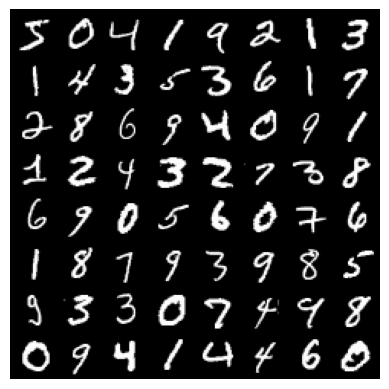

In [9]:
grid = torchvision.utils.make_grid(batch, nrow=8)
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()


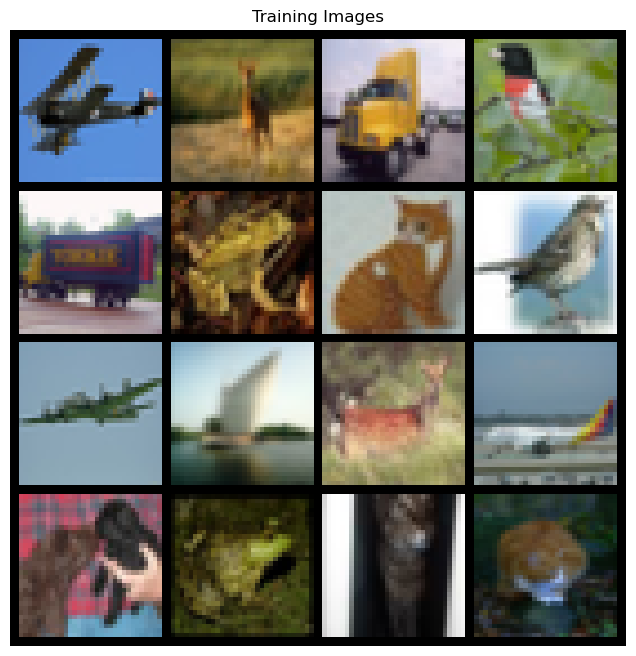

In [6]:
# Plot some training images
real_batch, _ = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    real_batch.to(device)[:16], 
    nrow=4,
    padding=2, normalize=True
).cpu(),(1,2,0)))
plt.show()

In [94]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, 
                 stride=2, padding=1, upsample: bool = True):
        super().__init__()
        self.updample = nn.Upsample(scale_factor=2, mode='bilinear') if upsample \
                        else nn.Identity()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size, stride, padding, bias=False
        )
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.norm2 = nn.InstanceNorm2d(out_channels)
        self.noise_linear1 = nn.Linear(1, out_channels)
        self.noise_linear1 = nn.Linear(1, out_channels)

    def forward(self, x, z):
        x = self.updample(x)
        
        x = self.conv1(x)
        x = x + self.noise_linear1(z)
        x = nn.functional.relu(self.norm1(x))

        x = self.conv2(x)
        x = x + self.noise_linear2(z)
        x = nn.functional.relu(self.norm2(x))

        return x


class Generator(nn.Module):
    def __init__(self, z_dim, ngf):
        super().__init__()  
        self.z_dim = z_dim
        self.ngf = ngf  
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        if z.ndim == 2:
            z = z[..., None, None]
        return self.main(z)

    
    def save_model(self, path):
        ckpt = {
            "config": {"z_dim": self.z_dim, "ngf": self.nfg},
            "state_dict": self.state_dict()
        }
        torch.save(ckpt, path)


class Discriminator(nn.Module):
    def __init__(self, ndf):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [110]:
netG = Generator(256, 32).to(device)
netG.apply(weights_init)
None

In [111]:
netD = Discriminator(32).to(device)
netD.apply(weights_init)
None

In [112]:
cls_ = CifarCls().to(device)
cls_.load_state_dict(torch.load('../reward_ckpt/cifar_cls.pt'))

<All keys matched successfully>

In [113]:
z = torch.randn(4, netG.z_dim, device=device)
x = netG(z)
y = netD(x)
print(x.shape, y.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4, 1, 1, 1])


In [114]:
optimizerG = optim.AdamW(netG.parameters(), lr=0.0004, betas=(0.5, 0.999))
optimizerD = optim.AdamW(netD.parameters(), lr=0.0006, betas=(0.5, 0.999))

In [115]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=8):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=(12, 6))
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Class `{classes[i]}`; proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()

Epoch: 30/30,  errD: 0.0990,  errG: 5.0844,  D(x): 0.8507,  D(G(z)): 0.0222 / 0.0099


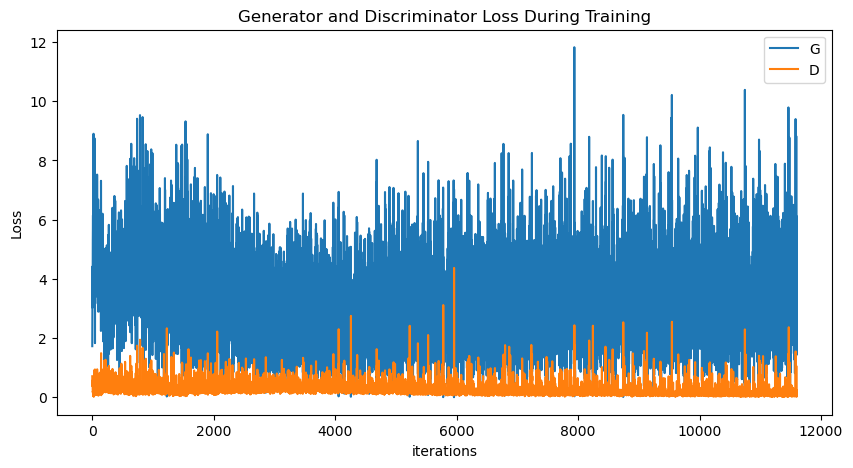

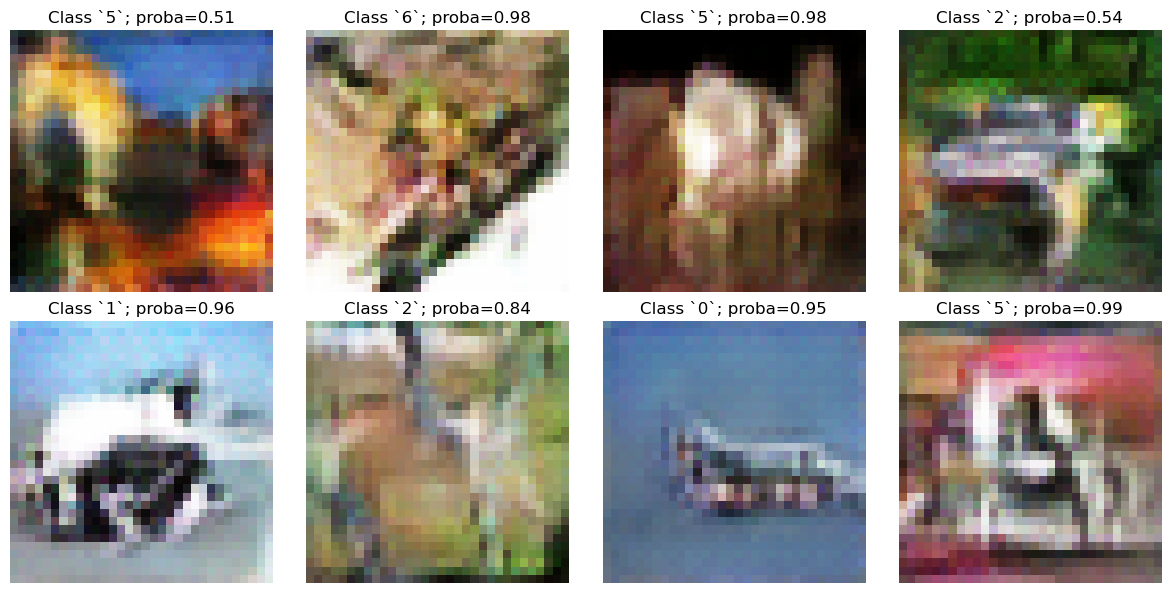

In [116]:
criterion = nn.BCELoss()

img_list = []
G_losses = []
D_losses = []
iters = 0
D_x = 0
num_epochs = 30
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        curr_batch_size = real_cpu.size(0)

        output = netD(real_cpu).view(-1)
        
        errD_real = nn.functional.softplus(-output).mean()
        errD_real.backward()
        D_x = nn.functional.sigmoid(output).mean().item()

        noise = torch.randn(curr_batch_size, netG.z_dim, 1, 1, device=device)
        fake = netG(noise)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = nn.functional.softplus(output).mean()
        errD_fake.backward()
        D_G_z1 = nn.functional.sigmoid(output).mean().item()
        
        errD = (errD_real + errD_fake) / 2
        optimizerD.step()

        netG.zero_grad()
        
        noise = torch.randn(curr_batch_size, netG.z_dim, 1, 1, device=device)
        fake = netG(noise)
        output = netD(fake).view(-1)
        
        errG = nn.functional.softplus(-output).mean()
        errG.backward()
        optimizerG.step()
        
        D_G_z2 = nn.functional.sigmoid(output).mean().item()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if iters % 200 == 0:
            clear_output(wait=True)
            print(
                f"Epoch: {epoch+1}/{num_epochs}, ",
                f"errD: {errD.item():.4f}, ",
                f"errG: {errG.item():.4f}, ",
                f"D(x): {D_x:.4f}, ",
                f"D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}"
            )
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(G_losses,label="G")
            plt.plot(D_losses,label="D")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
            
            with torch.no_grad():
                img_for_plotting = (fake.detach()[:8] + 1) / 2
                logits = cls_(img_for_plotting).cpu()
                (probs, classes) = logits.softmax(dim=1).max(dim=1)
                plot_annotated_images(img_for_plotting, (classes, probs), n_col=4)

        iters += 1

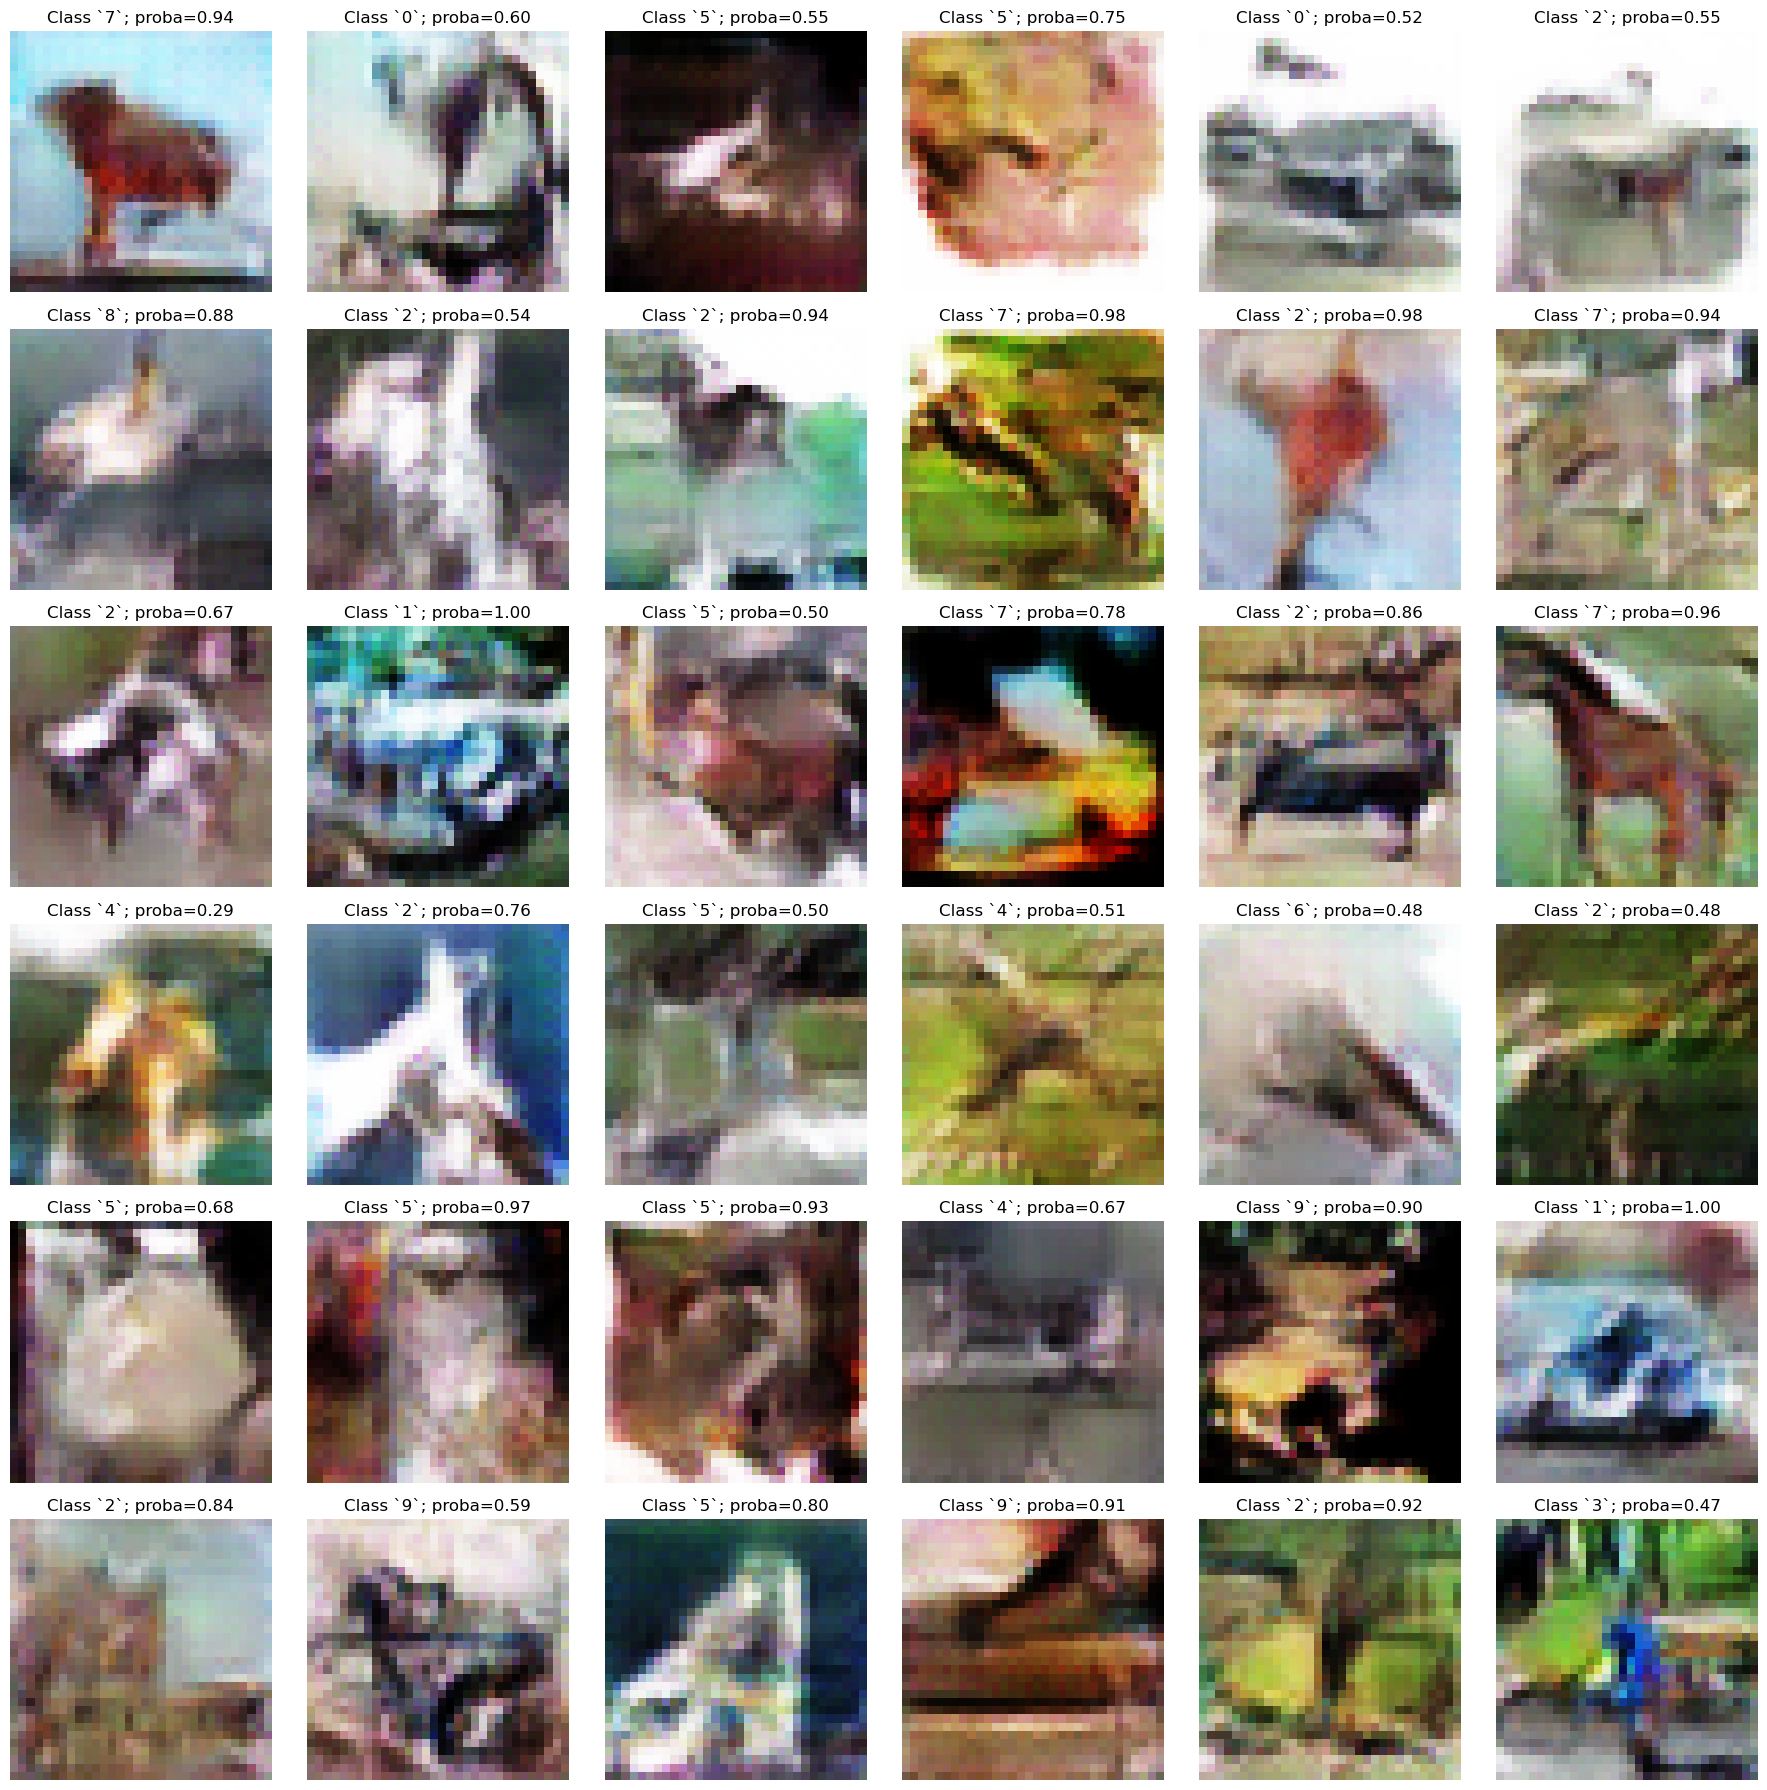

In [123]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=6):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=(18, 18))
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Class `{classes[i]}`; proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()


with torch.no_grad():
    img_for_plotting = (fake.detach()[:36] + 1) / 2
    logits = cls_(img_for_plotting).cpu()
    (probs, classes) = logits.softmax(dim=1).max(dim=1)
    plot_annotated_images(img_for_plotting, (classes, probs), n_col=6)

In [118]:
ckpt = {
    "config": {"z_dim": 256, "ngf": 32},
    "state_dict": netG.state_dict()
}
torch.save(ckpt, "../reward_ckpt/gan-cifar10-z_dim_256.pt")

In [42]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=8):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=(12, 6))
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Class `{classes[i]}`; proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()

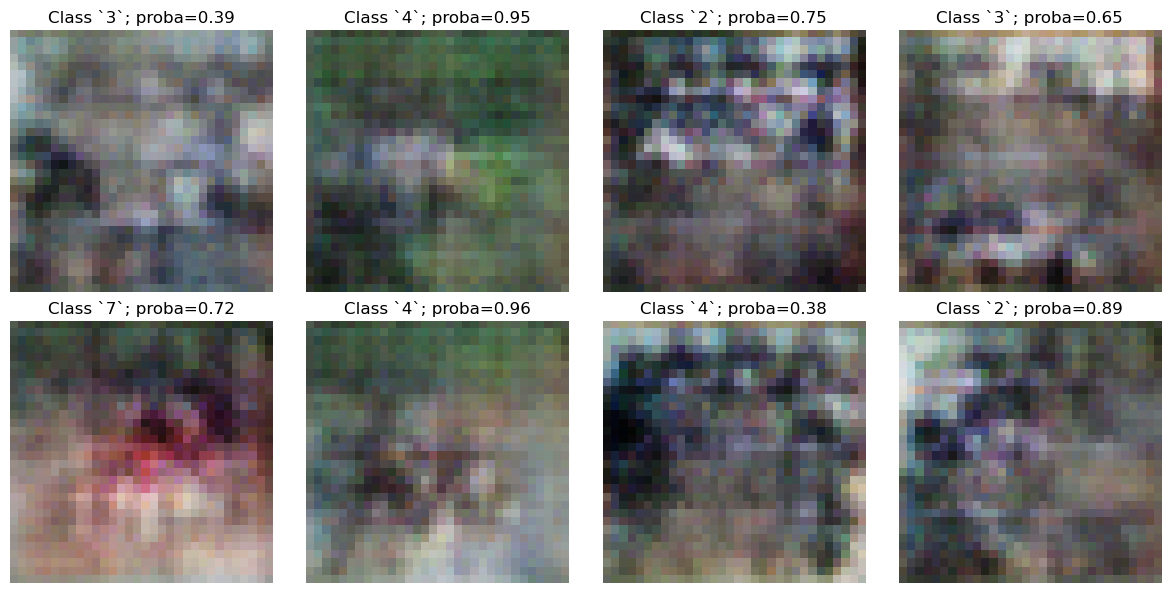

In [43]:
with torch.no_grad():
    img_for_plotting = (fake.detach()[:8] + 1) / 2
    logits = cls_(img_for_plotting)
    (probs, classes) = logits.softmax(dim=1).max(dim=1)
    plot_annotated_images(img_for_plotting, (classes, probs), n_col=4)

torch.return_types.max(
values=tensor([1.6712, 0.6971, 1.1446, 0.9999, 2.1319]),
indices=tensor([3, 1, 8, 2, 6]))

In [12]:
@torch.no_grad()
def plot_annotated_images(batch, classes_probas, n_col=8):
    classes, probas = classes_probas
    f, ax = plt.subplots(batch.size(0) // n_col, n_col, figsize=(12, 12))
    for i in range(batch.size(0)):
        row, col = divmod(i, n_col)
        ax[row, col].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
        ax[row, col].axis('off')
        ax[row, col].set_title(
            f"Image of class `{classes[i]}` with proba={probas[i]:.2f}"
        )
    plt.tight_layout()
    plt.show()

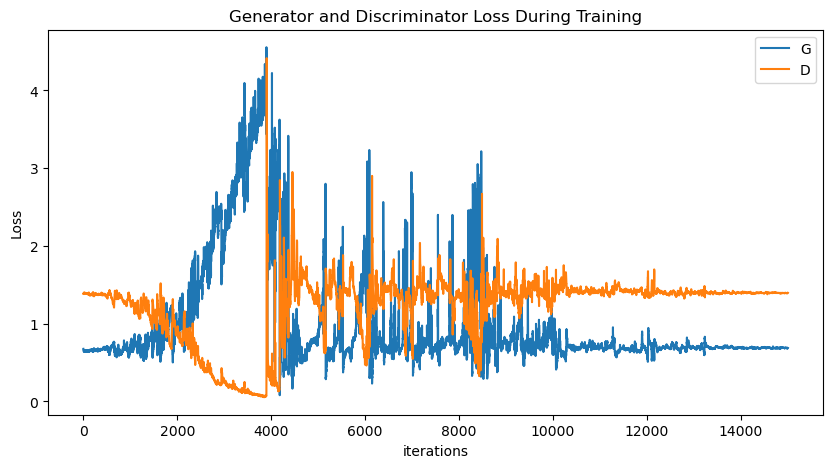

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [149]:
z = torch.randn(64, 50, 1, 1, device=device)
with torch.no_grad():
    fake = netG(z).detach().cpu()
    fake = (fake + 1) / 2  # Rescale to [0, 1]
    print(fake.shape)

torch.Size([64, 3, 128, 128])


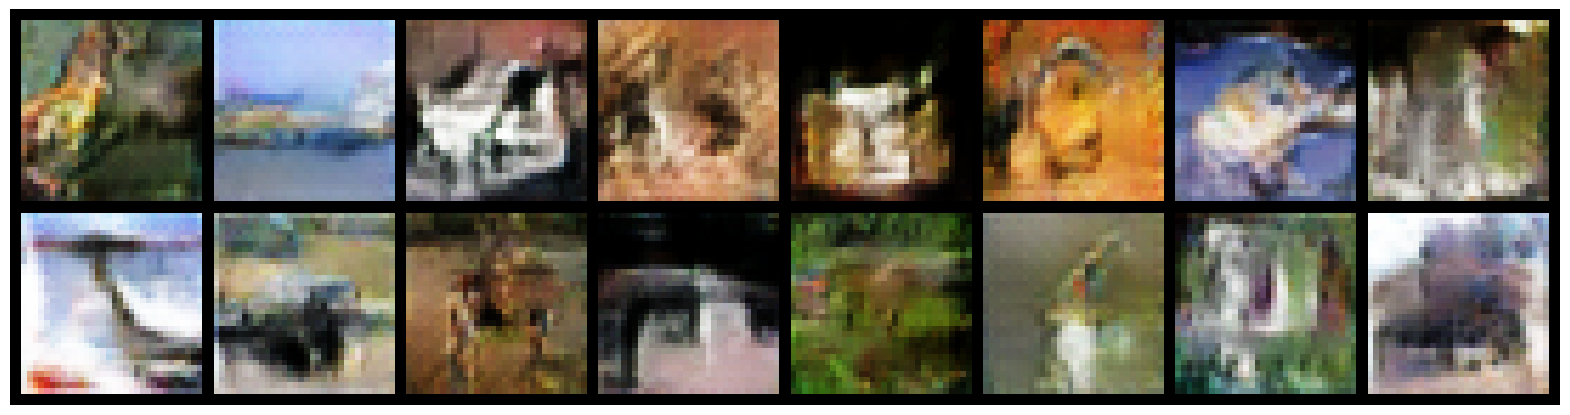

In [210]:
@torch.no_grad()
def show_batch_of_images(batch):
    batch = batch.cpu()
    grid = torchvision.utils.make_grid(batch, nrow=8, padding=2, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


plt.figure(figsize=(20, 10))
show_batch_of_images(fake[:16])

In [212]:
import sys
sys.path.append('../')
from sb.nn.cifar import CifarCls

cls_ = CifarCls().to(device)
cls_.load_state_dict(torch.load('../reward_ckpt/cifar_cls.pt'))

<All keys matched successfully>

In [216]:
with torch.no_grad():
    logits = cls_(fake[:16].to(device))
    probas = nn.Softmax(dim=1)(logits)
    pred, pred_probas = torch.max(probas, dim=1)
    
    print("Predicted classes:")
    print(pred.reshape(2, 8))
    print("Predicted probas:")
    print(pred_probas.reshape(2, 8))

Predicted classes:
tensor([[0.9820, 0.4181, 0.9994, 0.9985, 0.7475, 0.6135, 0.9719, 0.9873],
        [0.9324, 0.9987, 0.9809, 0.5958, 0.9853, 0.9755, 0.7669, 0.6220]],
       device='cuda:2')
Predicted probas:
tensor([[4, 0, 1, 3, 4, 9, 3, 5],
        [0, 1, 3, 4, 4, 7, 3, 1]], device='cuda:2')
